In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filepath = 'C:\\Users\\XXX\\Desktop\\Github repositories\\video_play.csv'
df = pd.read_csv(filepath)

In [3]:
df = df.drop(['stream_format', 'subscriber', 'device_id', 'channel'], axis=1).drop_duplicates().rename(columns={'player': 'platform'})
df['time'] = pd.to_datetime(df['time'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515670 entries, 0 to 526298
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   time      515670 non-null  datetime64[ns]
 1   login     515670 non-null  object        
 2   country   498933 non-null  object        
 3   platform  515670 non-null  object        
 4   game      512655 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 23.6+ MB


In [5]:
df.head()

,time,login,country,platform,game
0,2015-01-01 18:33:52,085c1eb7b587bfe654f0df7b4ba7f4fc4013636c,US,iphone_t,League of Legends
1,2015-01-01 23:35:33,5ad49a7b408ce452140b180dd6efb57a9f4d22c7,US,site,DayZ
2,2015-01-01 04:39:38,5b9a43e68f019185f55615d0b83019dee4b5d06f,US,site,League of Legends
3,2015-01-01 11:15:30,02c7797faa4d8a3ff4b0c14ee1764b6817b53d0b,CH,site,Dota 2
4,2015-01-01 11:28:19,b920c228acbcbebee26d9c79f6eb73b73a9480c7,FR,site,Heroes of the Storm


#### Question 1: Identifying ghosts users. How many distinct logins did not watch a single stream of any game (game column is NA)? What percentage of total distinct logins do these ghost logins represent? 

In [6]:
df['game'].isnull().sum()

3015

In [7]:
dist_logins = len(df.groupby('login').count()['game'].reset_index().query('game == 0'))
print(f'The number of distinct logins that belong to users that did not watch any stream is {dist_logins}.')

The number of distinct logins that belong to users that did not watch any stream is 654.


In [8]:
percent_of_total_dist_logins = round(dist_logins / df['login'].nunique() * 100, 2)
print(f'Ghost logins represent {percent_of_total_dist_logins}% of total unique logins.')

Ghost logins represent 0.25% of total unique logins.


In [9]:
df = df.dropna(subset=['game'])

#### Question 2: What are the most popular games streamed on Twitch on Jan 1, 2015 (total unique viewers for each game)? Plot a bar chart to visualise.

In [10]:
df_2a = df.groupby('game').nunique()['login'].reset_index().rename(columns={'login': 'num_views'}).nlargest(10, 'num_views')
df_2a

,game,num_views
23,League of Legends,89544
14,Dota 2,44762
10,Counter-Strike: Global Offensive,37114
22,Heroes of the Storm,20038
11,DayZ,16513
17,Gaming Talk Shows,15790
34,The Binding of Isaac: Rebirth,14495
1,Agar.io,8867
20,Hearthstone: Heroes of Warcraft,7400
39,World of Tanks,6821


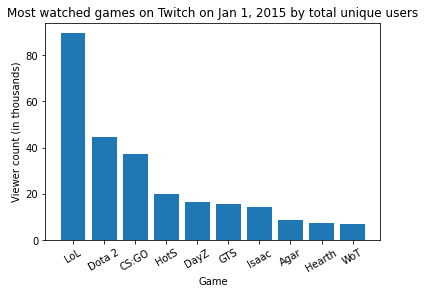

In [11]:
x = ['LoL', 'Dota 2', 'CS:GO', 'HotS', 'DayZ', 'GTS', 'Isaac', 'Agar', 'Hearth', 'WoT']
y = df_2a['num_views'] / 1000

ax = plt.subplot()
plt.bar(range(len(x)), y)
plt.title('Most watched games on Twitch on Jan 1, 2015 by total unique users')
plt.ylabel('Viewer count (in thousands)')
plt.xlabel('Game')
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x, rotation = 30);

#### Question 3: Most popular game by country. Among the top 10 countries where viewers are arising from (by total count of unique logins), what is the most popular game from each of these countries?
#### Concept: Returning the top value from each partition

In [12]:
df_3a = df.drop(index = df[df['country'].isnull()].index)
top_10_countries = df_3a.groupby('country').nunique()['login'].reset_index().nlargest(10, 'login')['country'].tolist()
df_3b = df_3a[df_3a['country'].isin(top_10_countries)].groupby(['country', 'game']).nunique()['login'].reset_index().rename(columns={'login': 'num_views'})

#### Rank function

In [13]:
df_3b['rank'] = df_3b.groupby('country')['num_views'].rank(ascending=False)
df_3b[df_3b['rank'] == 1][['country', 'game', 'num_views']].sort_values('num_views', ascending=False)

,country,game,num_views
184,US,League of Legends,34096
153,TW,Gaming Talk Shows,14526
100,RU,Dota 2,6684
31,DE,League of Legends,5825
14,CA,League of Legends,5756
70,GB,League of Legends,3276
137,TR,League of Legends,2754
81,PL,Counter-Strike: Global Offensive,2451
114,SE,Counter-Strike: Global Offensive,2176
48,FR,League of Legends,1338


#### Custom aggregation on groupby

In [14]:
df_3b.groupby('country').apply(lambda df_3c: df_3c.loc[df_3c['num_views'].idxmax()])[['game', 'num_views']].sort_values('num_views', ascending=False).reset_index()

,country,game,num_views
0,US,League of Legends,34096
1,TW,Gaming Talk Shows,14526
2,RU,Dota 2,6684
3,DE,League of Legends,5825
4,CA,League of Legends,5756
5,GB,League of Legends,3276
6,TR,League of Legends,2754
7,PL,Counter-Strike: Global Offensive,2451
8,SE,Counter-Strike: Global Offensive,2176
9,FR,League of Legends,1338


#### Question 4: Find the unique pairs of games which are most commonly watched together on Jan 1, 2015. Return the top 10 pairs by count of viewers.
#### Concept: Self-joins and similar to questions like which two products are most commonly sold together?

In [15]:
df_4 = df.merge(df, on='login')
df_4[df_4['game_x'] < df_4['game_y']].groupby(['game_x', 'game_y']).nunique()['login'].reset_index().nlargest(10, 'login').rename(columns={'login': 'num_viewers'})

,game_x,game_y,num_viewers
22,Agar.io,Counter-Strike: Global Offensive,2337
148,Rocket League,The Binding of Isaac: Rebirth,1846
151,SpeedRunners,The Binding of Isaac: Rebirth,1062
65,Counter-Strike: Global Offensive,League of Legends,947
58,Counter-Strike: Global Offensive,Dota 2,650
147,Rocket League,SpeedRunners,588
132,Heroes of the Storm,League of Legends,513
99,Dota 2,Heroes of the Storm,502
3,ARK: Survival Evolved,DayZ,489
81,DayZ,League of Legends,485


#### Question 5:  Agar.io and Counter-Strike: Global Offensive is the pair of games that is the most frequently viewed together. How many distinct viewers watched both games on Jan 1, 2015 within each hour of the day (show count of distinct viewers of both games by hour)?
#### Concept: Self-join on two columns

In [16]:
df['hour'] = df['time'].dt.hour
df_5 = df.merge(df, on=['login', 'hour'])
df_5[(df_5['game_x'] == 'Agar.io') & (df_5['game_y'] == 'Counter-Strike: Global Offensive')].groupby('hour').nunique()['login'].reset_index().rename(columns={'login': 'num_viewers'}).sort_values('hour')

,hour,num_viewers
0,0,3
1,1,5
2,2,2
3,3,1
4,4,1
5,5,3
6,6,2
7,7,1
8,8,2
9,11,16


#### Question 6: Label each game based on its popularity of viewership
#### Concept: SQL CASE WHEN equivalent

In [17]:
df_6 = df.groupby('game').nunique()['login'].reset_index()
df_6['popularity'] = 'Hot'
df_6.loc[df_6['login'].between(10000, 50000), 'popularity'] = 'Popular'
df_6.loc[df_6['login'].between(100, 10000, inclusive='left'), 'popularity'] = 'Trending Up'
df_6.loc[df_6['login'] < 100, 'popularity'] = 'New'
df_6.sort_values('login', ascending=False)[['popularity', 'game']]

,popularity,game
23,Hot,League of Legends
14,Popular,Dota 2
10,Popular,Counter-Strike: Global Offensive
22,Popular,Heroes of the Storm
11,Popular,DayZ
17,Popular,Gaming Talk Shows
34,Popular,The Binding of Isaac: Rebirth
1,Trending Up,Agar.io
20,Trending Up,Hearthstone: Heroes of Warcraft
39,Trending Up,World of Tanks


#### Question 7: Create a pivot table to show country on rows, platform on columns and number of unique viewers on values. Only show top 10 countries and top 10 platforms by count of unique viewership.

In [18]:
top_10_countries = df.groupby('country').nunique()['login'].reset_index().nlargest(10, 'login')['country'].tolist()
top_10_platforms = df.groupby('platform').nunique()['login'].reset_index().nlargest(10, 'login')['platform'].tolist()
df_7a = df[(df['country'].isin(top_10_countries )) & (df['platform'].isin(top_10_platforms))]

#### Using pd.pivot_table()

In [19]:
df_7b = df_7a.pivot_table(index='country', columns='platform', values='login', aggfunc='nunique').fillna(0).astype('int')
df_7b['total'] = df_7b.sum(axis=1)
df_7b.sort_values('total', ascending=False)

platform,amazon,android,embed,frontpage,home,ipad_t,iphone_t,site,xbox360,xbox_one,total
country,,,,,,,,,,,
US,331,9655,1405,42,1434,7135,17222,44139,461,1972,83796
TW,0,2990,1478,0,3,633,930,11230,0,5,17269
DE,44,3382,513,9,47,1056,1361,10564,22,64,17062
RU,1,2399,2146,956,11,2259,1826,7334,5,9,16946
CA,6,1636,259,11,94,1488,2166,7571,34,122,13387
GB,64,1224,261,3,184,1680,1550,6479,42,298,11785
SE,0,624,279,1,15,829,909,5251,3,23,7934
PL,0,1828,155,0,2,99,147,4203,5,2,6441
TR,0,1508,230,2,1,304,613,2898,0,1,5557


#### Using pd.assign()

In [20]:
df_7c = df_7a.assign(
 amazon = np.where(df_7a['platform']=='amazon', df_7a['login'], pd.NA),
 android = np.where(df_7a['platform']=='android', df_7a['login'], pd.NA),
 embed = np.where(df_7a['platform']=='embed', df_7a['login'], pd.NA),
 frontpage = np.where(df_7a['platform']=='frontpage', df_7a['login'], pd.NA),
 home = np.where(df_7a['platform']=='home', df_7a['login'], pd.NA),
 ipad_t = np.where(df_7a['platform']=='ipad_t', df_7a['login'], pd.NA),
 iphone_t = np.where(df_7a['platform']=='iphone_t', df_7a['login'], pd.NA),
 site = np.where(df_7a['platform']=='site', df_7a['login'], pd.NA),
 xbox360 = np.where(df_7a['platform']=='xbox360', df_7a['login'], pd.NA),
 xbox_one = np.where(df_7a['platform']=='xbox_one', df_7a['login'], pd.NA)
  ).groupby('country').nunique()[['amazon', 'android', 'embed', 'frontpage', 'home' , 'ipad_t', 'iphone_t', 'site', 'xbox360', 'xbox_one']]
df_7c['total'] = df_7c.sum(axis=1)
df_7c.sort_values('total', ascending=False)

,amazon,android,embed,frontpage,home,ipad_t,iphone_t,site,xbox360,xbox_one,total
country,,,,,,,,,,,
US,331,9655,1405,42,1434,7135,17222,44139,461,1972,83796
TW,0,2990,1478,0,3,633,930,11230,0,5,17269
DE,44,3382,513,9,47,1056,1361,10564,22,64,17062
RU,1,2399,2146,956,11,2259,1826,7334,5,9,16946
CA,6,1636,259,11,94,1488,2166,7571,34,122,13387
GB,64,1224,261,3,184,1680,1550,6479,42,298,11785
SE,0,624,279,1,15,829,909,5251,3,23,7934
PL,0,1828,155,0,2,99,147,4203,5,2,6441
TR,0,1508,230,2,1,304,613,2898,0,1,5557


#### Question 8: Among viewers that logged in at least twice on Jan 1, 2015, find the longest and shortest interval between any two log in time for the same viewer.
#### Concept: Self-joins and working with datetimes

In [21]:
df_8a = df.merge(df, on='login').query('time_x < time_y')
df_8a['timediff'] = df_8a['time_y'] - df_8a['time_x']
df_8a['interval'] = pd.NA
df_8a.loc[df_8a['timediff'] == df_8a['timediff'].min(), 'interval'] = 'shortest'
df_8a.loc[df_8a['timediff'] == df_8a['timediff'].max(), 'interval'] = 'longest'
df_8a[df_8a['interval'].isin(['shortest', 'longest'])][['interval', 'timediff']].drop_duplicates()

,interval,timediff
23409,shortest,0 days 00:00:01
169470,longest,0 days 23:59:13


#### Question 9: Among viewers that logged in at least twice on Jan 1, 2015, find the longest and shortest interval between any two CONSECUTIVE log in time for the same viewer.
#### Concept: Window function with shift and working with datetimes

In [22]:
df_9 = df.copy()
df_9['prev'] = df_9.sort_values('time').groupby('login')['time'].shift(1)
df_9['timediff'] = df_9['time'] - df_9['prev']
df_9['interval'] = pd.NA
df_9.loc[df_9['timediff'] == df_9['timediff'].min(), 'interval'] = 'shortest'
df_9.loc[df_9['timediff'] == df_9['timediff'].max(), 'interval'] = 'longest'
df_9[df_9['interval'].isin(['shortest', 'longest'])][['interval', 'timediff']].drop_duplicates()

,interval,timediff
11116,shortest,0 days 00:00:00
405390,longest,0 days 23:55:37


#### Question 10: What is the trend of viewership count during the day? Is there a time period where there is peak traffic? If yes, what game(s) are driving that peak traffic?
#### Concept: Time series charts, window functions transform and rank

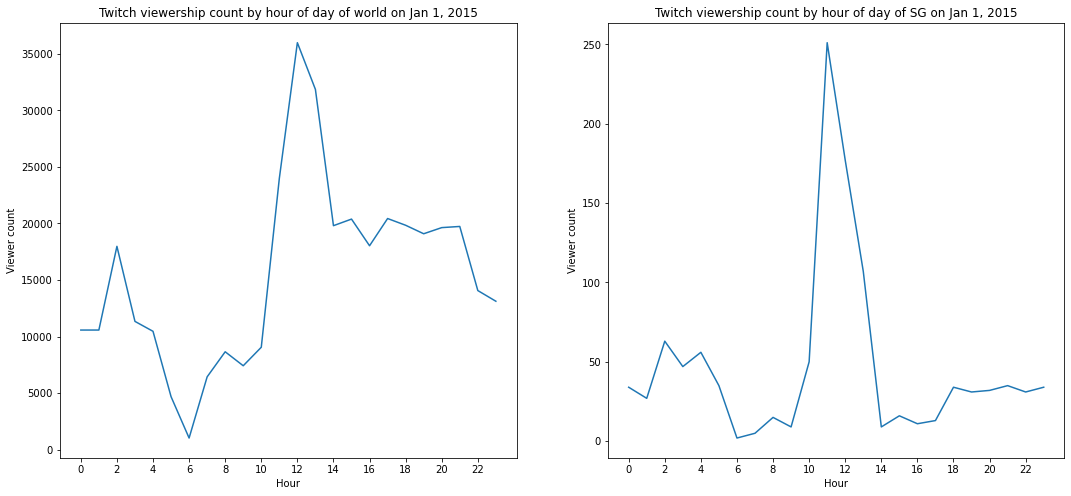

In [23]:
df_10 = df.copy()
df_10['hour'] = df_10['time'].dt.hour
df_10_w = df_10.groupby('hour').nunique()['login'].reset_index()
df_10_s = df_10[df_10['country'] == 'SG'].groupby('hour').nunique()['login'].reset_index()

x = range(24)
y1 = df_10_w['login']
y2 = df_10_s['login']

plt.figure(figsize=(18,8))

ax = plt.subplot(1,2,1)
plt.plot(x, y1)
plt.title('Twitch viewership count by hour of day of world on Jan 1, 2015')
plt.ylabel('Viewer count')
plt.xlabel('Hour')
ax.set_xticks(range(0, 24, 2))

ax2 = plt.subplot(1,2,2)
plt.plot(x, y2)
plt.title('Twitch viewership count by hour of day of SG on Jan 1, 2015')
plt.ylabel('Viewer count')
plt.xlabel('Hour')
ax2.set_xticks(range(0, 24, 2));

In [24]:
# Twitch viewership hits the highest viewer count from 1100 to 1300 for world. 
df_10b = df_10[df_10['hour'].between(11, 13)].groupby(['hour', 'game']).nunique()['login'].reset_index().rename(columns={'login': 'num_viewers'})
df_10b['sum_viewers'] = df_10b.groupby('hour')['num_viewers'].transform(sum)
df_10b['percent_of_total_viewers'] = (round(df_10b['num_viewers'] / df_10b['sum_viewers'] * 100)).astype('int')
df_10b['rank'] = df_10b.groupby('hour')['num_viewers'].rank(ascending=False).astype('int')
df_10b[df_10b['rank'] <= 3].sort_values(['hour', 'rank']).drop('sum_viewers', axis=1)

,hour,game,num_viewers,percent_of_total_viewers,rank
7,11,Dota 2,16082,67,1
5,11,Counter-Strike: Global Offensive,4217,17,2
11,11,Heroes of the Storm,2322,10,3
25,12,Dota 2,17036,47,1
23,12,Counter-Strike: Global Offensive,15323,42,2
29,12,Heroes of the Storm,2025,6,3
43,13,Dota 2,14090,44,1
41,13,Counter-Strike: Global Offensive,13811,43,2
49,13,Heroes of the Storm,2450,8,3


In [25]:
# The peak in game viewership from 1100 to 1300 was driven by Dota 2 and Counter-Strike with them accounting for the 
# majority of total views. Surprisingly, the most popular game for the day League of Legends was not popular at this time.